In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from sklearn.cluster import MeanShift
# Import CMasher to register colormaps
import cmasher as cmr
import geopandas as gpd
import cftime
import glob
from scipy.stats import linregress
from decimal import Decimal, ROUND_DOWN
import statsmodels.api as sm
import statsmodels.formula.api as smf

/home/estudiantes/anaconda/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
#Coordenadas de estaciones 
cor=pd.read_csv("clusterinf_Had.csv")

#Seleciconando las latitudes y las longitudes
lat=cor.lat
lon=cor.Lon

In [3]:
#Cargando los datos de ERA5-Land
# Usar glob para seleccionar todos los archivos CSV en la ruta
archivos_nc = sorted(glob.glob("/home/andreagvc/data/ERA/ERA/ERA_*_hourly_rec*.nc"))

#Combinando los datos de ERA
ds_combinado=xr.open_mfdataset(archivos_nc,combine="by_coords")

In [4]:
#Seleccionando las variables

Tw_ERA=ds_combinado.TWB_d
T_ERA=ds_combinado.T_d
q_ERA=ds_combinado.q_d

In [5]:
#Haciendo la serie de tiempo  de los promedios
Tw_ERA_s=Tw_ERA.resample(time="YE").mean("time")
Tw_ERA_s=Tw_ERA_s.mean("sid")

T_ERA_s=T_ERA.resample(time="YE").mean("time")
T_ERA_s=T_ERA_s.mean("sid")

q_ERA_s=q_ERA.resample(time="YE").mean("time")
q_ERA_s=q_ERA_s.mean("sid")

In [6]:
#Cargando los datos de las estaciones
df=pd.read_csv("IDD.csv",header=None)
ID=df[(df[0]>="760011-99999")&(df[0]<="780160-13601")] 
ID1=ID[0].str.split(pat="-", expand=True) #Separando 
ID["ID"]=ID1[0].astype(int)

esta=pd.read_fwf("ID.txt",header=None)
p=esta[1]
filtered_df = ID[(ID["ID"]).isin(p)]
filtered_df #Encontrando los datos de las estaciones que ocupamos
lat=filtered_df[2].values
lon=filtered_df[3].values
ele=filtered_df[4].values

#Agregando la elevación al dataframe
esta["elevacion"]=ele
esta["Lat"]=lat
esta["Lon"]=lon
esta["Lugar"]=filtered_df[1].values

/tmp/ipykernel_162613/136930437.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID["ID"]=ID1[0].astype(int)


In [7]:
#Cargando los datos de las estaciones Had_ISD
da_list=[]
for i,ii in enumerate(esta[1]):
    datos=xr.open_dataset(f"/home/andreagvc/data/ERA/ERA/Datos_HAD/{ii}99999_estadisticos.nc")
    datos=datos.assign_coords(estacion=ii)
    datos=datos.expand_dims('estacion')
    da_list.append(datos)

In [8]:
HAD=xr.concat(da_list,dim='estacion')

In [9]:
#Seleccionando las variables promedio para hacer la comparaci{on}
HAD_Tw=HAD.Twmean.where(HAD.Twmean.time.dt.year>1978, drop=True)
HAD_T=HAD.Tmean.where(HAD.Tmean.time.dt.year>1978, drop=True)
HAD_SH=HAD.SHmean.where(HAD.SHmean.time.dt.year>1978, drop=True)


<xarray.DataArray 'TWB_d' (time: 45)> Size: 360B
dask.array<stack, shape=(45,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    number   int64 8B 0
  * time     (time) datetime64[ns] 360B 1979-12-31 1980-12-31 ... 2023-12-31
Attributes:
    units:      degrees Celsius
    long_name:  Wet bulb temperature daily 
<xarray.DataArray 'TWB_d' (year: 45)> Size: 360B
dask.array<_nanmax_skip-aggregate, shape=(45,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    number   int64 8B 0
  * year     (year) int64 360B 1979 1980 1981 1982 1983 ... 2020 2021 2022 2023


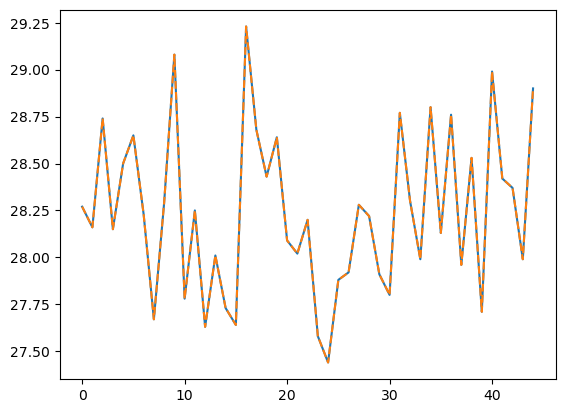

In [10]:
#Esto solo es para corroborar que usando resample o groupby los resultados son los mismos.
sid_sampl=Tw_ERA.sel(sid=[761220, 762200, 762250, 762430, 762560, 763230, 763420, 763820,
       763900, 763930, 764020, 764050, 764230, 764580, 764710, 764990,
       765390, 765480, 765560, 765710, 765770, 765810, 765850, 766340,
       766440, 766540, 766650, 766830, 766870, 766920, 766950, 767410,
       767500, 767620, 768050, 768430, 768480, 769030])
sid_mean=sid_sampl.resample(time="YE").mean(["time","sid"])
sid_max=sid_sampl.resample(time="YE").max(["time",'sid'])
sid_groupmax=sid_sampl.groupby(sid_sampl.time.dt.year).max().max('sid')
print(sid_mean)
print(sid_groupmax)
#lt.plot(sid_mean)
plt.plot(sid_max)
plt.plot(sid_groupmax,linestyle='--')
plt.show()

In [11]:
#Calculando la serie de tiempo
HAD_Tw_s=HAD_Tw.resample(time="YE").mean("time")
HAD_Tw_s=HAD_Tw_s.mean("estacion")

HAD_T_s=HAD_T.resample(time="YE").mean("time")
HAD_T_s=HAD_T_s.mean("estacion")

HAD_q_s=HAD_SH.resample(time="YE").mean("time")
HAD_q_s=HAD_q_s.mean("estacion")

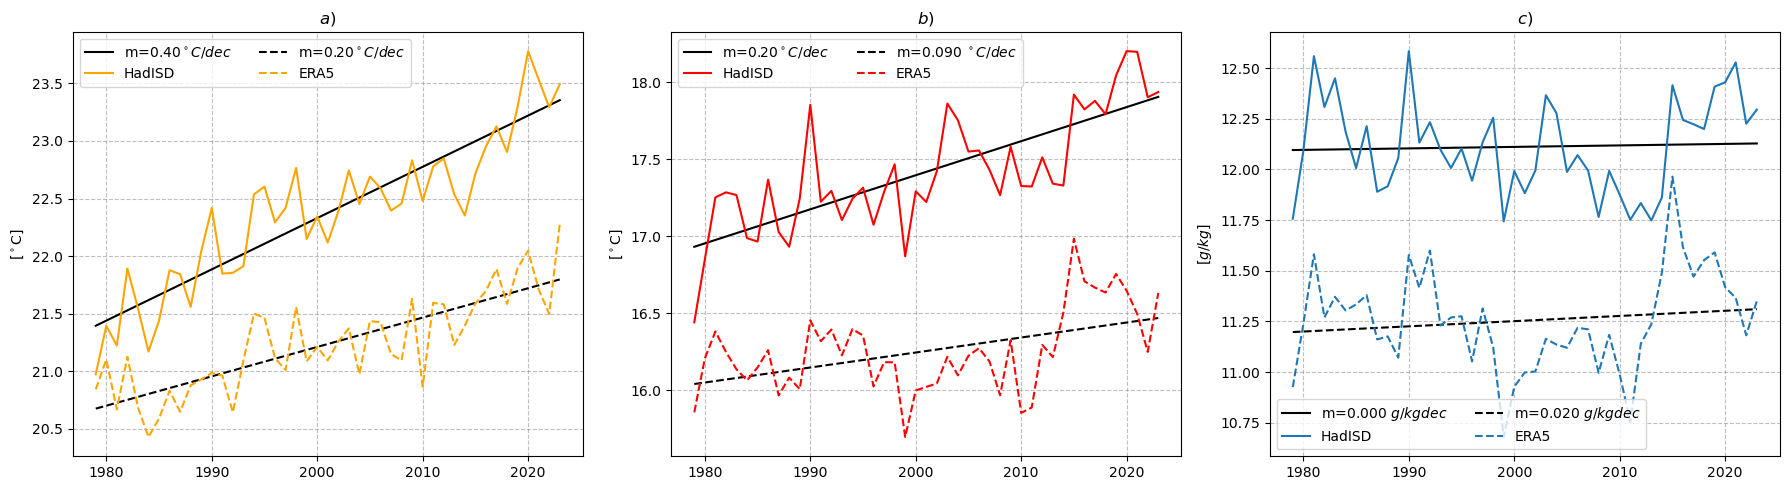

In [12]:
#Graficando la tendencia solo para los promedios
fig = plt.figure(figsize=(18, 5))
plt.subplot(1,3,1)

x=Tw_ERA_s.time.dt.year
y=HAD_T_s
slope, intercept, r_value, p_value, std_err = linregress(x, y)
slope1=Decimal(float(slope)).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, slope*x + intercept, color="black",label=f"m={slope1*10}$^\circ$$C/dec$")
plt.plot(x,y,label="HadISD",c="orange")

x1=Tw_ERA_s.time.dt.year
y1=T_ERA_s
slope, intercept, r_value, p_value, std_err = linregress(x1, y1)
slope1=Decimal(float(slope)).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, slope*x + intercept, color="black",linestyle="--",label=f"m={slope1*10}$^\circ$$C/dec$")
plt.plot(x1,y1,label="ERA5",c="orange",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')
plt.title("$a)$")
plt.ylabel("[$^\circ$C]")
plt.legend(ncol=2)

plt.subplot(1,3,2)
x=Tw_ERA_s.time.dt.year
y=HAD_Tw_s-273.15

slope, intercept, r_value, p_value, std_err = linregress(x, y)
slope1=Decimal(float(slope)).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, slope*x + intercept, color="black",label=f"m={slope1*10}$^\circ$$C/dec$")
plt.plot(x,y,label="HadISD",c="red")

x1=Tw_ERA_s.time.dt.year
y1=Tw_ERA_s
slope, intercept, r_value, p_value, std_err = linregress(x1, y1)
slope1=Decimal(float(slope)).quantize(Decimal("0.001"), rounding=ROUND_DOWN)
plt.plot(x, slope*x + intercept, color="black",linestyle="--",label=f"m={slope1*10} $^\circ$$C/dec$")

plt.plot(x1,y1,label="ERA5",c="red",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')
plt.title("$b)$")
plt.ylabel("[$^\circ$C]")
plt.legend(ncol=2)

plt.subplot(1,3,3)

x=Tw_ERA_s.time.dt.year
y=HAD_q_s*1000

slope, intercept, r_value, p_value, std_err = linregress(x, y)
slope1=Decimal(float(slope)).quantize(Decimal("0.001"), rounding=ROUND_DOWN)
plt.plot(x, slope*x + intercept, color="black",label=f"m={slope1*10} $g/kg dec$")

plt.plot(x,y,label="HadISD")

x1=Tw_ERA_s.time.dt.year
y1=q_ERA_s*1000

slope, intercept, r_value, p_value, std_err = linregress(x1, y1)
slope1=Decimal(float(slope)).quantize(Decimal("0.001"), rounding=ROUND_DOWN)
plt.plot(x, slope*x + intercept, color="black",linestyle="--",label=f"m={slope1*10} $g/kg dec$")

plt.plot(x1,y1,label="ERA5",c="#1f77b4",linestyle="--")
plt.grid(color='gray', alpha=0.5, linestyle='--')
plt.title("$c)$")
plt.ylabel("$[g/kg]$")
plt.legend(ncol=2)
plt.tight_layout()
plt.savefig("tendencia_ERAVSHAD.svg")
plt.show()

In [13]:
#Encontrando los máximos 

#Haciendo la serie de tiempo 
Tw_ERA_smax=Tw_ERA.resample(time="YE").max(["time","sid"])
#Tw_ERA_smax=Tw_ERA_smax.max("sid")

T_ERA_smax=T_ERA.resample(time="YE").max(["time","sid"])
#T_ERA_smax=T_ERA_smax.max("sid")

q_ERA_smax=q_ERA.resample(time="YE").max(["time","sid"])
#q_ERA_smax=q_ERA_smax.max("sid")

In [14]:
#Seleccionando las variables promedio para hacer la comparaci{on}
HAD_Tw_max=HAD.Twmax.where(HAD.Twmax.time.dt.year>1978, drop=True)
HAD_T_max=HAD.Tmax.where(HAD.Tmax.time.dt.year>1978, drop=True)
HAD_SH_max=HAD.SHmax.where(HAD.SHmax.time.dt.year>1978, drop=True)

In [15]:
#Calculando la serie de tiempo
HAD_Tw_smax=HAD_Tw_max.resample(time="YE").max("time")
HAD_Tw_smax=HAD_Tw_smax.max("estacion")

HAD_T_smax=HAD_T_max.resample(time="YE").max("time")
HAD_T_smax=HAD_T_smax.max("estacion")

HAD_q_smax=HAD_SH_max.resample(time="YE").max("time")
HAD_q_smax=HAD_q_smax.max("estacion")

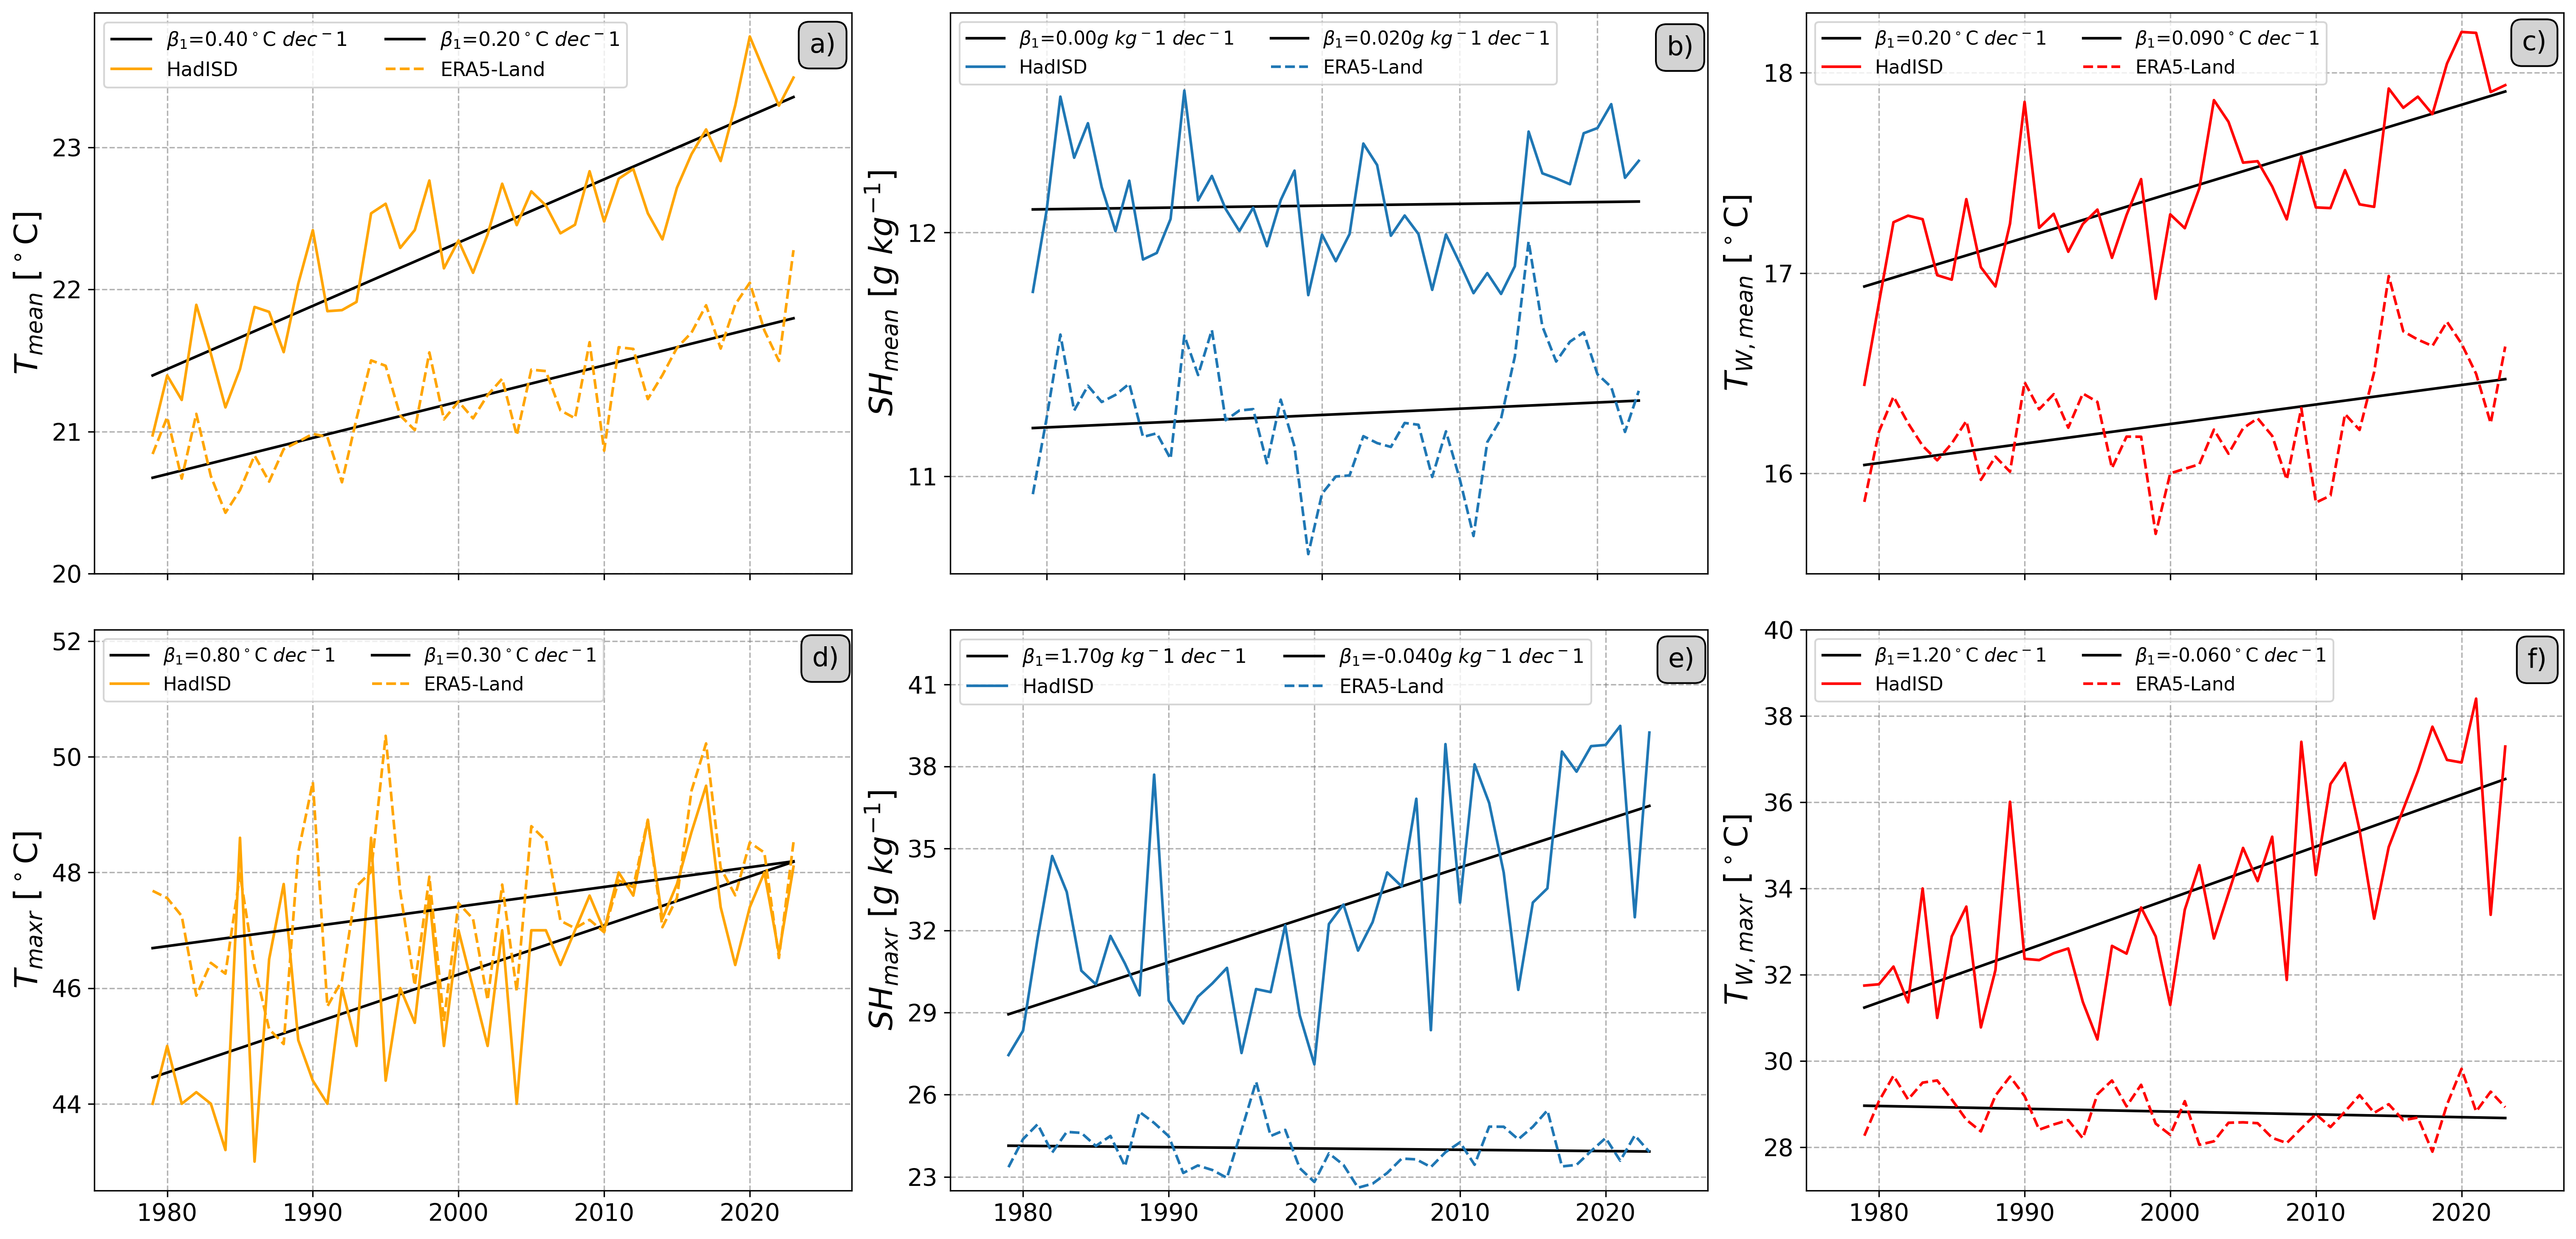

In [16]:
#Graficando la serie de tiempo
fig = plt.figure(figsize=(25,12),dpi=300)

plt.subplot(2,3,1)

x=Tw_ERA_s.time.dt.year
y=HAD_T_s

Tiempo = np.array(x)#Variable independiente
bulbohumedo=np.array(y)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")

#plt.plot(x, slope*x + intercept, color="black",label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")
plt.plot(x,y,label="HadISD",c="orange")
plt.text(2025, 23.72, "a)", fontsize=15, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.xlim(1975,2027) 

x1=Tw_ERA_s.time.dt.year
y1=T_ERA_s

Tiempo = np.array(x1)#Variable independiente
bulbohumedo=np.array(y1)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x1, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")
plt.plot(x1,y1,label="ERA5-Land",c="orange",linestyle="--")
plt.grid(color='gray', alpha=0.6, linestyle='--')
plt.ylabel("$T_{mean}$ [$^\circ$C]",fontsize=18)
plt.legend(ncol=2,fontsize=11)
plt.xticks(fontsize=13,color="white")
plt.yticks((np.arange(20,24,1)),fontsize=13.5)


plt.subplot(2,3,3)
x=Tw_ERA_s.time.dt.year
y=HAD_Tw_s-273.15

Tiempo = np.array(x)#Variable independiente
bulbohumedo=np.array(y)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")
plt.plot(x,y,label="HadISD",c="red")
plt.text(2025, 18.15, "c)", fontsize=15, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.xlim(1975,2027)  



x1=Tw_ERA_s.time.dt.year
y1=Tw_ERA_s

Tiempo = np.array(x1)#Variable independiente
bulbohumedo=np.array(y1)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.001"), rounding=ROUND_DOWN)
plt.plot(x1, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")
plt.plot(x1,y1,label="ERA5-Land",c="red",linestyle="--")
plt.ylim(15.5,18.3)
plt.grid(color='gray', alpha=0.6, linestyle='--')
plt.ylabel("$T_{W,mean}$ [$^\circ$C]",fontsize=18)
plt.legend(ncol=2,loc="upper left",fontsize=10.5)
plt.xticks(fontsize=13,color="white")
plt.yticks((np.arange(16,19,1)),fontsize=13.5)

plt.subplot(2,3,2)

x=Tw_ERA_s.time.dt.year
y=HAD_q_s*1000
Tiempo = np.array(x)#Variable independiente
bulbohumedo=np.array(y)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$g$ $kg^{-1}$ $dec^{-1}$")
plt.text(2026, 12.76, "b)", fontsize=15, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.xlim(1973,2028) 

plt.plot(x,y,label="HadISD")

x1=Tw_ERA_s.time.dt.year
y1=q_ERA_s*1000

Tiempo = np.array(x1)#Variable independiente
bulbohumedo=np.array(y1)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.001"), rounding=ROUND_DOWN)
plt.plot(x1, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$g$ $kg^{-1}$ $dec^{-1}$")

plt.plot(x1,y1,label="ERA5-Land",c="#1f77b4",linestyle="--")
plt.grid(color='gray', alpha=0.6, linestyle='--')
plt.ylim(10.60,np.max(y)+0.32)
plt.ylabel("$SH_{mean}$ [$g$ $kg^{-1}$]",fontsize=18)
plt.legend(ncol=2,loc="upper left",fontsize=10.5)
plt.xticks(fontsize=13,color="white")
plt.yticks((np.arange(11,13,1)),fontsize=13.5)
#plt.tight_layout()
#plt.savefig("tendencia_ERAVSHAD.svg")
#plt.show()
plt.subplot(2,3,4)

x=Tw_ERA_smax.time.dt.year
y=HAD_T_smax

Tiempo = np.array(x)#Variable independiente
bulbohumedo=np.array(y)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")

plt.plot(x,y,label="HadISD",c="orange")
plt.text(2025.2, 51.7, "d)", fontsize=15, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.xlim(1975,2027) 
x1=Tw_ERA_smax.time.dt.year
y1=T_ERA_smax

Tiempo = np.array(x1)#Variable independiente
bulbohumedo=np.array(y1)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x1, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")
plt.plot(x1,y1,label="ERA5-Land",c="orange",linestyle="--")
plt.grid(color='gray', alpha=0.6, linestyle='--')
plt.ylabel("$T_{maxr}$ [$^\circ$C]",fontsize=18)
plt.legend(ncol=2,loc="upper left",fontsize=10.5)
plt.ylim(42.5,52.2)
plt.xticks(fontsize=13.5)
plt.yticks(fontsize=13.5)

plt.subplot(2,3,6)
x=Tw_ERA_smax.time.dt.year
y=HAD_Tw_smax-273.15
plt.xlim(1975,2027) 

Tiempo = np.array(x)#Variable independiente
bulbohumedo=np.array(y)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")
plt.plot(x,y,label="HadISD",c="red")
plt.text(2025.2, 39.3, "f)", fontsize=15, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))

x1=Tw_ERA_smax.time.dt.year
y1=Tw_ERA_smax

Tiempo = np.array(x1)#Variable independiente
bulbohumedo=np.array(y1)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.001"), rounding=ROUND_DOWN)
plt.plot(x1, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$^\circ$C $dec^{-1}$")
plt.plot(x1,y1,label="ERA5-Land",c="red",linestyle="--")
plt.grid(color='gray', alpha=0.6, linestyle='--')

plt.ylabel("$T_{W,maxr}$ [$^\circ$C]",fontsize=18)
plt.legend(ncol=2,loc="upper left",fontsize=10.5)
plt.ylim(27,40)
plt.xticks(fontsize=13.5)
plt.yticks(fontsize=13.5)

plt.subplot(2,3,5)

x=Tw_ERA_smax.time.dt.year
y=HAD_q_smax*1000
Tiempo = np.array(x)#Variable independiente
bulbohumedo=np.array(y)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.01"), rounding=ROUND_DOWN)
plt.plot(x, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$g$ $kg^{-1}$ $dec^{-1}$")
plt.plot(x,y,label="HadISD")
plt.xlim(1975,2027) 

x1=Tw_ERA_smax.time.dt.year
y1=q_ERA_smax*1000
Tiempo = np.array(x1)#Variable independiente
bulbohumedo=np.array(y1)
    # Añadir una constante para el término de intersección en el modelo
X = sm.add_constant((Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modelo = sm.OLS(bulbohumedo, X).fit()
slope1=Decimal(float(modelo.params[1])).quantize(Decimal("0.001"), rounding=ROUND_DOWN)
plt.plot(x1, modelo.predict(X), color='black',label=fr"$\beta_{1}$={slope1*10}$g$ $kg^{-1}$ $dec^{-1}$")
plt.plot(x1,y1,label="ERA5-Land",c="#1f77b4",linestyle="--")
plt.grid(color='gray', alpha=0.6, linestyle='--')

plt.ylabel("$SH_{maxr}$ [$g$ $kg^{-1}$]",fontsize=18)

plt.text(2025.2, 41.9, "e)", fontsize=15, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.legend(ncol=2,loc="upper left",fontsize=11)
plt.ylim(22.5,43)

plt.xticks(fontsize=13.5)
plt.yticks((np.arange(23,43,3)),fontsize=13.5)
plt.subplots_adjust(hspace=0.1,wspace=0.13)
plt.savefig("tendencia_ERAVSHAD.svg",bbox_inches="tight",dpi=300)
plt.savefig("tendencia_ERAVSHAD.png",bbox_inches="tight",dpi=300)
plt.show()

In [17]:
coefT=[]
coefT2=[]
pvalue=[]
R2T=[]
for i, ii in enumerate(T_ERA.sid):
        #Haciendo la regresión lineal para una estación
    # Datos de ejemplo (concentración de un elemento químico y altura de las plantas)
    Tiempo = np.array(np.unique(T_ERA[i].resample(time="YE").max(["time"]).time.dt.year))#Variable independiente
    bulbohumedo=np.array(T_ERA[i].resample(time="YE").max(["time"]))
    # Añadir una constante para el término de intersección en el modelo
    X = sm.add_constant(np.float64(Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
    modelo = sm.OLS(bulbohumedo, X).fit()
    
    coefT.append(modelo.params[0])
    coefT2.append(modelo.params[1])
    pvalue.append(modelo.pvalues)
    R2T.append(modelo.rsquared)
    

In [18]:
coefT=[]
coef2=[]
pvalue=[]
R2=[]
for i, ii in enumerate(T_ERA.sid):
        #Haciendo la regresión lineal para una estación
    # Datos de ejemplo (concentración de un elemento químico y altura de las plantas)
    Tiempo = np.array(np.unique(q_ERA[i].resample(time="YE").max(["time"]).time.dt.year))#Variable independiente
    bulbohumedo=np.array((q_ERA[i].resample(time="YE").max(["time"]))*1000)
    # Añadir una constante para el término de intersección en el modelo
    X = sm.add_constant(np.float64(Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
    modelo = sm.OLS(bulbohumedo, X).fit()
    
    coefT.append(modelo.params[0])
    coef2.append(modelo.params[1])
    pvalue.append(modelo.pvalues)
    R2.append(modelo.rsquared)
    

In [19]:
coefT=[]
coefTW2=[]
pvalue=[]
R2TW=[]
for i, ii in enumerate(T_ERA.sid):
        #Haciendo la regresión lineal para una estación
    # Datos de ejemplo (concentración de un elemento químico y altura de las plantas)
    Tiempo = np.array(np.unique(Tw_ERA[i].resample(time="YE").max("time").time.dt.year))#Variable independiente
    bulbohumedo=np.array(Tw_ERA[i].resample(time="YE").max(["time"]))
    # Añadir una constante para el término de intersección en el modelo
    X = sm.add_constant(np.float64(Tiempo))
    # Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
    modelo = sm.OLS(bulbohumedo, X).fit()
    
    coefT.append(modelo.params[0])
    coefTW2.append(modelo.params[1])
    pvalue.append(modelo.pvalues)
    R2TW.append(modelo.rsquared)
    

In [20]:
from cartopy.mpl.ticker import LongitudeFormatter

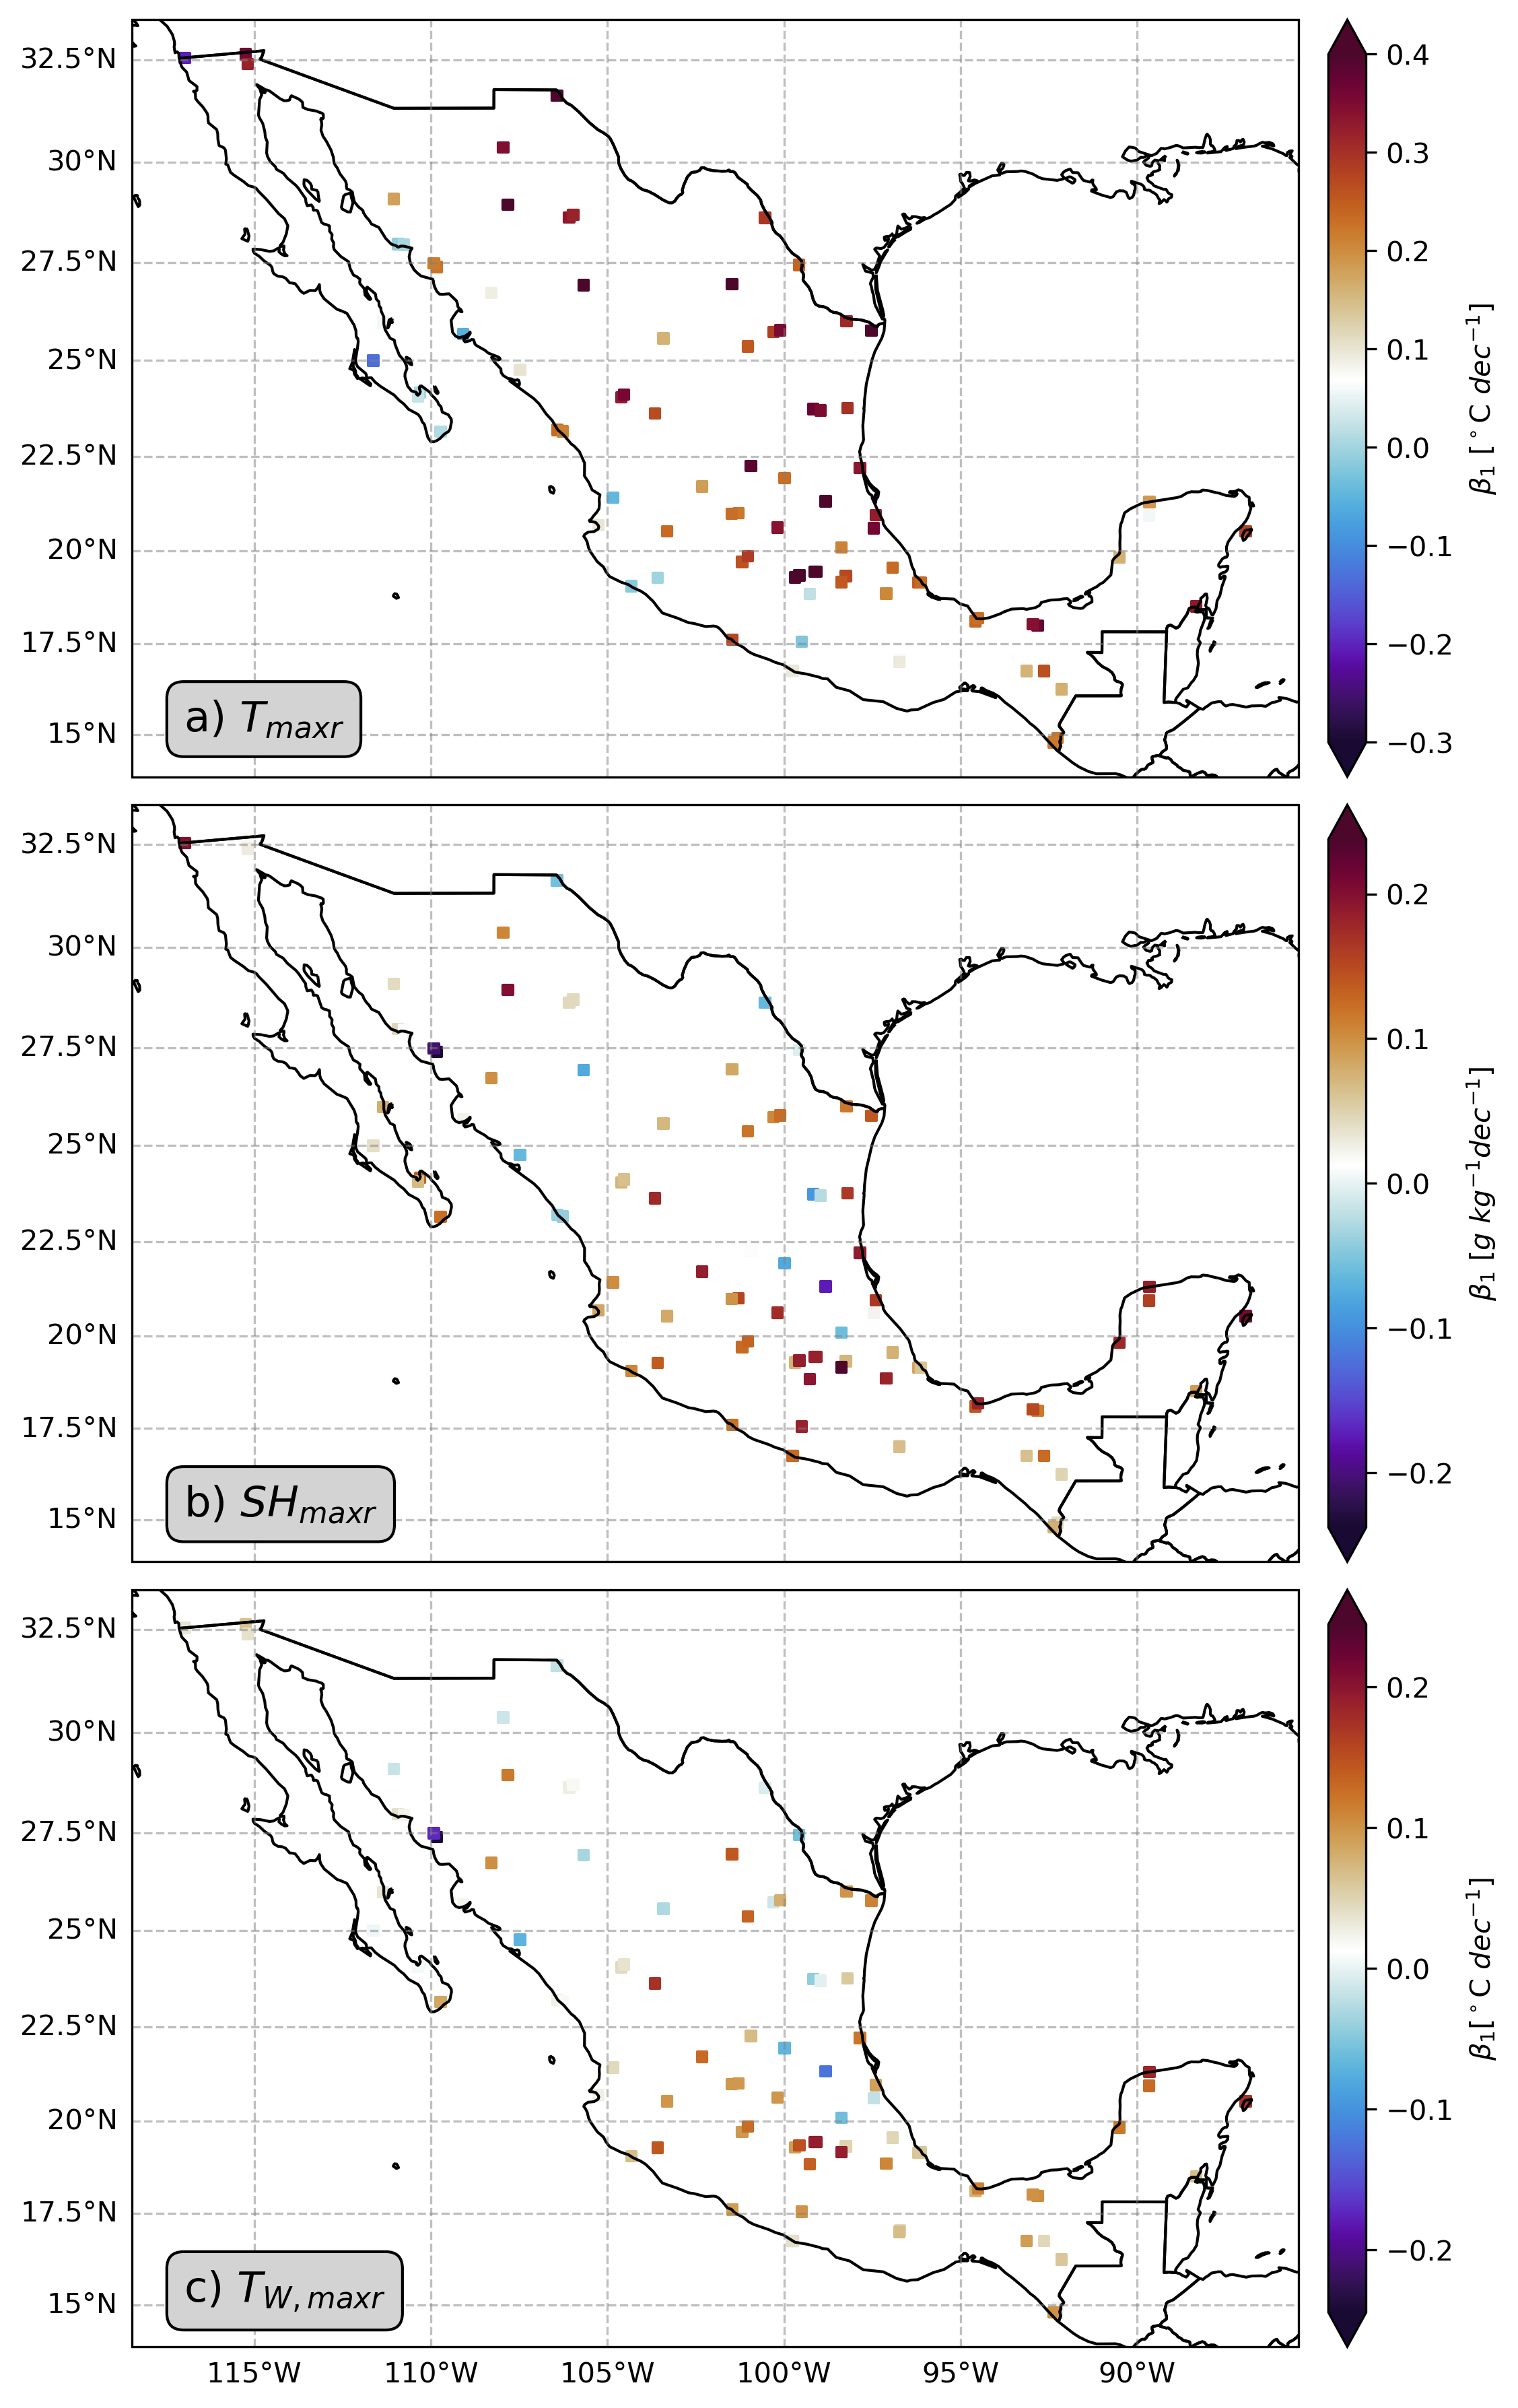

In [24]:
list=[coefT2,coef2,coefTW2]
p=["a) $T_{maxr}$","b) $SH_{maxr}$", "c) $T_{W,maxr}$"]
x=lon.astype(float)
y=lat.astype(float)
color=['cmr.fusion_r','cmr.fusion_r']
fig = plt.figure(figsize=(15, 12),dpi=300)
n=0
for i,ii in enumerate(list):
    ax = fig.add_subplot(3, 1, n+1, projection=ccrs.Mercator())
    ax.set_global
    ax.add_feature(cfeature.BORDERS)
    # fusion
    if n<4:
        c=np.array(ii)
        ccmap=cmr.get_sub_cmap(color[0], 0, 0.95)
        if n==0:
            cs=ax.scatter(x=x,y=y,c=np.array(c)*10,cmap=ccmap,marker='s', s=12,transform=ccrs.PlateCarree(),vmin=-0.3, vmax=0.4) 
        else:
            cs=ax.scatter(x=x,y=y,c=np.array(c)*10,cmap=ccmap,marker='s', s=12,transform=ccrs.PlateCarree(),vmin=np.min(np.array(c)*10), vmax=-np.min(np.array(c)*10))
                         
        c=np.array(ii)
        #cs=ax.scatter(x=x,y=y,c=np.array(c)*10,cmap=ccmap,marker='s', s=12,transform=ccrs.PlateCarree(),vmin=np.min(np.array(c)*10), vmax=-np.min(np.array(c)*10))
        cbar=plt.colorbar(cs,orientation='vertical',fraction=0.2,extend="both",shrink=1,pad=0.01)
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        gl=ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
        ax.xlabels_top = False# It should turn off the upper x ticks
        gl.top_labels = gl.right_labels = False
        if n==0 or n==1:
            gl.bottom_labels=False
        else:
            gl.bottom_labels=True
        ax.text(-117, 16, p[n], fontsize=15, color="black",
            ha="left", va="top", bbox=dict(facecolor="lightgray", edgecolor="black",
                                           boxstyle="round", pad=0.4),
            transform=ccrs.PlateCarree())
        plt.xticks(fontsize=20,)
        plt.yticks(fontsize=20)
        
# Estilizar
        
        if n==1:
            cbar.set_label(r"$\beta_{1}$ [$g$ $kg^{-1} dec^{-1}$]")
            
        elif n==0:
            cbar.set_label(r"$\beta_{1}$ [$^\circ$C $dec^{-1}$]")
        else:
            cbar.set_label(r"$\beta_{1}$[$^\circ$C $dec^{-1}$]")
            
   
        
    n=n+1
        
        
    
    

#Gráfica de los coeficientes de los valores promedio
    
    
plt.tight_layout(pad=1)  
plt.savefig("pmax_ERAvsHAD.svg",bbox_inches="tight",dpi=300)
        
    

In [ ]:
#Función para el ciclo anual
def ciclo_mean(variable,coor,unidades=None):

    ciclo=variable.groupby("time.month").mean()
    ciclo=ciclo.mean(coor)-unidades
    return ciclo

In [ ]:
#Función para el ciclo anual
def ciclo_max(variable,coor,unidades=None):

    ciclo=variable.groupby("time.month").max()
    ciclo=ciclo.max(coor)-unidades
    return ciclo

In [ ]:
#ERA

#Ciclo anual mean
Tw_ERA_a=ciclo_mean(Tw_ERA,"sid",unidades=0)
T_ERA_a=ciclo_mean(T_ERA,"sid",unidades=0)
q_ERA_a=ciclo_mean(q_ERA,"sid",unidades=0)

#Ciclo anual max
Tw_ERA_am=ciclo_max(Tw_ERA,"sid",unidades=0)
T_ERA_am=ciclo_max(T_ERA,"sid",unidades=0)
q_ERA_am=ciclo_max(q_ERA,"sid",unidades=0)

#HadISD
Tw_Had_a=ciclo_mean(HAD_Tw,"estacion",unidades=0)
T_Had_a=ciclo_mean(HAD_T,"estacion",unidades=0)
q_Had_a=ciclo_mean(HAD_SH,"estacion",unidades=0)

#Ciclo anual max
Tw_Had_am=ciclo_max(HAD_Tw_max,"estacion",unidades=0)
T_Had_am=ciclo_max(HAD_T_max,"estacion",unidades=0)
q_Had_am=ciclo_max(HAD_SH_max,"estacion",unidades=0)

In [ ]:
def figciclo(data1,data2,label1,label2,ylabel,color,linestyle="-",legend=False):
    meses=['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
    plt.plot(meses,data1,label=label1,linestyle=linestyle,color=color)
    plt.plot(meses,data2,label=label2,linestyle="--",color=color)
    plt.ylabel(ylabel,fontsize=14)
    plt.xticks(fontsize=14,rotation=45)
    plt.yticks(fontsize=14)
    plt.grid(linestyle="--",alpha=0.5,c="gray")
    ax = plt.gca()  # gca() obtiene el objeto de los ejes actuales

# Configurar los ticks enteros en los ejes X e Y
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=10,loc="lower center")

In [ ]:
import matplotlib.ticker as ticker

In [ ]:
fig = plt.figure(figsize=(15, 8),dpi=300)

plt.subplot(2,3,1)
figciclo(T_ERA_a,T_Had_a,"ERA5-Land","HadISD"," [$^{\circ}$C]",color="orange",linestyle="-",legend=False)
plt.text(0.1, 26.5, "a) $T_{mean}$", fontsize=15, color="black",
            ha="left", va="top", bbox=dict(facecolor="lightgray", edgecolor="black",
                                           boxstyle="round", pad=0.4))
plt.xticks(color="white")


plt.subplot(2,3,2)
figciclo(q_ERA_a*1000,q_Had_a*1000,"ERA5-Land","HadISD","[$g$ $kg^{-1}$]",color="#1f77b4",linestyle="-",legend=False)
plt.xticks(color="white")
plt.text(0.1, 15.3, "b) $SH_{mean}$ ", fontsize=15, color="black",
            ha="left", va="top", bbox=dict(facecolor="lightgray", edgecolor="black",
                                           boxstyle="round", pad=0.4))

plt.subplot(2,3,3)
figciclo(Tw_ERA_a,Tw_Had_a-273.15,"ERA5-Land","HadISD"," [$^{\circ}$C]",color="red",linestyle="-",legend=False)
plt.xticks(color="white")
plt.text(0.1, 21.4, "c) $T_{Wmean}$", fontsize=15, color="black",
            ha="left", va="top", bbox=dict(facecolor="lightgray", edgecolor="black",
                                           boxstyle="round", pad=0.4))

plt.subplot(2,3,4)
figciclo(T_ERA_am,T_Had_am,"ERA5-Land","HadISD","[$^{\circ}$C]",color="orange",linestyle="-",legend=True)
plt.text(0.1, 50.5, "d) $T_{max}$", fontsize=15, color="black",
            ha="left", va="top", bbox=dict(facecolor="lightgray", edgecolor="black",
                                           boxstyle="round", pad=0.4))


plt.subplot(2,3,5)
figciclo(q_ERA_am*1000,q_Had_am*1000,"ERA5-Land","HadISD","[$g$ $kg^{-1}$]",color="#1f77b4",linestyle="-",legend=True)
# Obtener los ejes actuales
plt.text(-0.1, 39.5, "e) $SH_{max}$", fontsize=15, color="black",
            ha="left", va="top", bbox=dict(facecolor="lightgray", edgecolor="black",
                                           boxstyle="round", pad=0.4))
plt.yticks(np.arange(20,41,4))

plt.subplot(2,3,6)
figciclo(Tw_ERA_am,Tw_Had_am-273.15,"ERA5-Land","HadISD"," [$^{\circ}$C]",color="red",linestyle="-",legend=True)
plt.text(0.1, 38.5, "f) $T_{Wmax}$", fontsize=15, color="black",
            ha="left", va="top", bbox=dict(facecolor="lightgray", edgecolor="black",
                                           boxstyle="round", pad=0.4))

plt.tight_layout(pad=0.5,h_pad=-2)
plt.savefig("cicloERAVSHAD_rec.svg",bbox_inches="tight",dpi=300)